# 0. Installation and imports

In [1]:
import pytorch_lightning as pl

from pytorch_lightning.loggers import WandbLogger

/home/gerard/PycharmProjects/Deforestation-Classification/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [26]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [27]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [28]:
category_to_label = convertlabeldict = {
    1: 'Cargo', 
    2:'Military', 
    3:'Carrier', 
    4:'Cruise', 
    5:'Tankers'
}

train['category_label'] = train['category'].map(category_to_label)
train.head()

,image,category,category_label
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [29]:
train, valid = train_test_split(train, test_size=0.1, random_state=0, stratify=train['category'])

In [30]:
train = train.reset_index(drop=True)
train.head()

,image,category,category_label
0,2279386.jpg,2,Military
1,2894573.jpg,5,Tankers
2,2782661.jpg,2,Military
3,2903056.jpg,3,Carrier
4,2842955.jpg,3,Carrier


In [31]:
valid = valid.reset_index(drop=True)
valid.head()

,image,category,category_label
0,1824988.jpg,4,Cruise
1,2786215.jpg,1,Cargo
2,2888474.jpg,1,Cargo
3,2902626.jpg,5,Tankers
4,2860160.jpg,5,Tankers


In [32]:
print(f"Train: {len(train)} samples / Valid: {len(valid)} samples.")

Train: 5626 samples / Valid: 626 samples.


In [33]:
print(category_to_label)

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}


<AxesSubplot: >

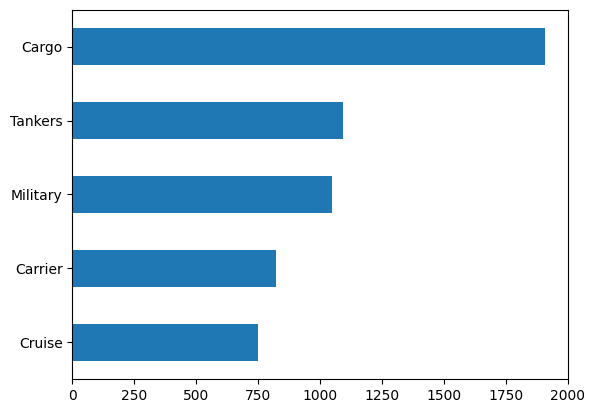

In [34]:
train['category_label'].value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot: >

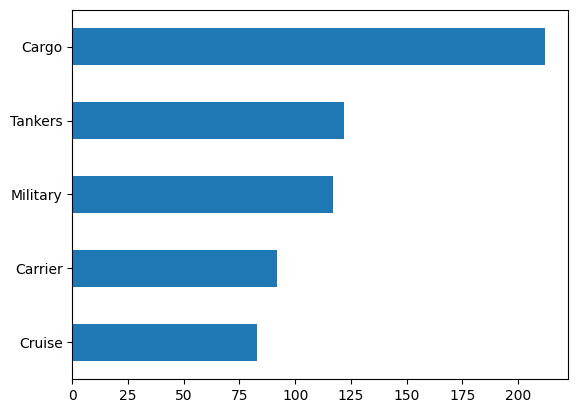

In [35]:
valid['category_label'].value_counts().sort_values().plot(kind = 'barh')

# 2. DataModule

In [3]:
from typing import Dict, Optional, Union
from pathlib import Path

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

In [4]:
class ShipDataset(Dataset):
    """This dataset provides maritime scenes of optical aerial images from visible spectrum."""
    def __init__(self, root_data_dir: Union[str, Path], metadata_df: pd.DataFrame, transforms = None):
        self.root_data_dir = Path(root_data_dir)
        self.metadata_df = metadata_df
        self.transforms = transforms

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        image_metadata = self.metadata_df.iloc[idx]
        image_file = self.root_data_dir / "images" / image_metadata["image"]
        image = torch.tensor(np.array(Image.open(image_file)))
        
        target = image_metadata["category"]
        sample = {"image": image, "target": target}

        if self.transforms:
            sample = self.transforms(sample["image"])

        return sample

In [7]:
class ShipDataModule(pl.LightningDataModule):
    def __init__(self, root_data_dir: str = './data', batch_size: int = 32, transforms: Dict = {"train": None, "valid": None, "test": None}):
        super().__init__()
        self.root_data_dir = Path(root_data_dir).resolve()
        self.batch_size = batch_size
        self.num_classes = 5
        
        self.transforms = transforms
        

    def prepare_data(self):
        """Define the logic to download the dataset or do any previous preprocessing."""

    def setup(self, stage: str = None):
        if stage == 'fit' or stage is None:
            full_train_metadata_df = pd.read_csv(self.root_data_dir / "train.csv")
            train_metadata_df, valid_metadata_df = train_test_split(full_train_metadata_df, test_size=0.1, random_state=0, stratify=full_train_metadata_df['category'])

            self.train_ds = ShipDataset(self.root_data_dir, train_metadata_df, transforms = self.transforms["train"])
            self.valid_ds = ShipDataset(self.root_data_dir, valid_metadata_df, transforms = self.transforms["valid"])

        if stage == 'test' or stage is None:
            test_metadata_df = pd.read_csv(self.root_data_dir / "test.csv")
            self.test_ds = ShipDataset(self.root_data_dir, test_metadata_df, transforms = self.transforms["test"])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)


    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size)


    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)


In [8]:
dm = ShipDataModule()
dm.setup()

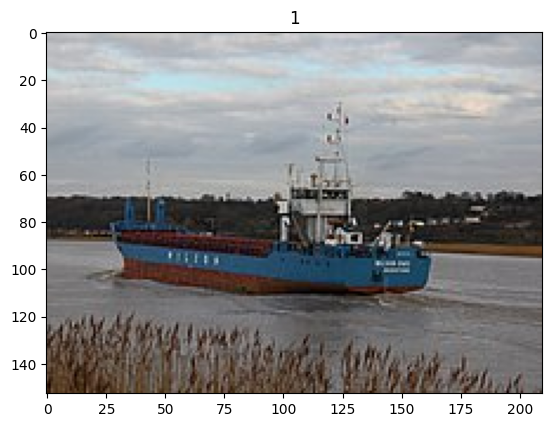

In [9]:
sample = dm.train_ds[np.random.randint(len(dm.train_ds))]
plt.imshow(sample["image"])
plt.title(sample["target"])
plt.show()

# 3. Callbacks

In [10]:
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples

def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })


# 4. LightningModule

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

In [12]:
class TimmModel(pl.LightningModule):

    def __init__(self, model, num_classes=5, learning_rate=1e-2):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.num_classes = num_classes
        self.model = self.create_timm_model(model)

        self.loss = F.cross_entropy
        self.accuracy = torchmetrics.Accuracy()

    def create_timm_model(self, model):
        model.classifier.out_features = self.num_classes

    def forward(self, x):
        # TODO: implement fastai model structure: backbone --> head so we can use self.num_classes to set the head output
        output = self.model(x)
        return output

    def training_step(self, batch, batch_idx):
        images, target = batch
        logits = self.forward(images)
        loss = self.loss(logits, target)

        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        images, target = batch
        logits = self.forward(images)
        loss = self.loss(logits, target)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger=True)

        return loss
        
    def test_step(self, batch, batch_idx):
        images, target = batch
        logits = self.forward(images)
        loss = self.loss(logits, target)
        
        # test metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [1]:
import timm

/home/gerard/PycharmProjects/Deforestation-Classification/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [5]:
timm_model = timm.create_model('densenet201', pretrained=True, num_classes=5)  #https://rwightman.github.io/pytorch-image-models/
for param in timm_model.parameters():
    param.requires_grad = False

In [15]:
timm_model = timm.create_model('densenet201', pretrained=True)

In [16]:
model = TimmModel(timm_model, num_classes=5)

/home/gerard/PycharmProjects/Deforestation-Classification/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


# 5. Transforms

List of transforms:

- RandomResizedCrop
- RandomRotation
- CenterCrop
- Normalize

In [17]:
from torchvision import transforms

In [18]:
train_transforms = transforms.Compose([
                                    transforms.RandomResizedCrop(256,scale=(0.8, 1.0),ratio=(0.75, 1.33)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.CenterCrop(224),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                   ])

In [19]:
valid_transforms = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])

In [20]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])

# 6. Train and Evaluate

In [21]:
# Init our data pipeline
transforms = {
    "train": train_transforms,
    "valid": valid_transforms,
    "test": test_transforms
    }
dm = ShipDataModule(batch_size=4, transforms=transforms)
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

# Init our model
timm_model = timm.create_model('densenet201', pretrained=True)  #https://rwightman.github.io/pytorch-image-models/
model = TimmModel(timm_model, dm.num_classes)

# Initialize wandb logger
wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     progress_bar_refresh_rate=20, 
                     gpus=1, 
                     logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                ImagePredictionLogger(val_samples)],
                     checkpoint_callback=checkpoint_callback)


# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test()

# Close wandb run
wandb.finish()

: 

: 